<a href="https://colab.research.google.com/github/dannyodeleon/100-pandas-puzzles/blob/master/colabs_image_classification_cs2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [110]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


plt.style.use('ggplot')

%matplotlib inline 

from skimage import io, color, filters
from skimage.transform import resize, rotate
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers, optimizers

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

from google.colab import files
from skimage.color import rgb2gray


import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import itertools

from tensorflow.keras.datasets import cifar10
AUTOTUNE = tf.data.experimental.AUTOTUNE ## tf.data transformation parameters

import timeit
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

# If using datasets from download, not keras

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict



In [74]:
# Load and prep the data

def load_and_featurize_data():
    # the data, shuffled and split between train and test sets
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()
    
    # convert class vectors to binary class matrices a.k.a. one hot encoding 
    Y_train = to_categorical(y_train, nb_classes) 
    Y_test = to_categorical(y_test, nb_classes)
    
    

    # reshape input into format Conv2D layer likes
    #MAYBE USEFUL for inputting and formatting cifar 10 images for demo
    #X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 3)
    #X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 3)

    # conversion and normalization of X
    X_train = X_train.astype('float32')  # data was unit8 [0-255]
    X_test = X_test.astype('float32')    # data was unit8 [0-255]
    X_train /= 255  # normalizing (scaling from 0 to 1)
    X_test /= 255   # normalizing (scaling from 0 to 1)


    return X_train, X_test, Y_train, Y_test, y_train, y_test

X_train, X_test, Y_train, Y_test, y_train, y_test = load_and_featurize_data()

In [ ]:
(X_train_1, y_train_1), (X_test_1, y_test_1) = cifar10.load_data()


In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

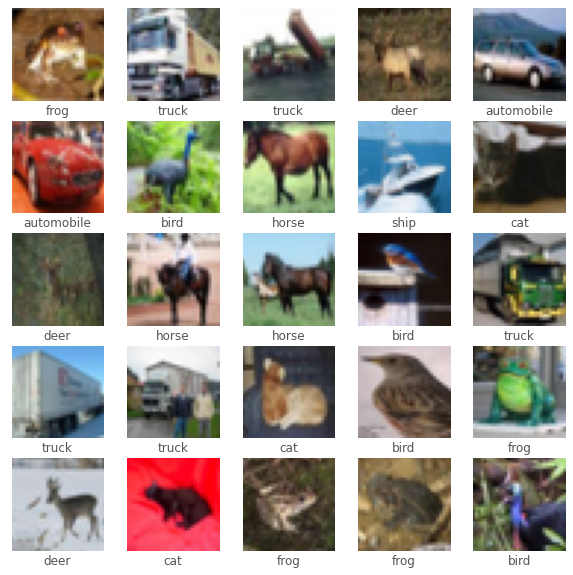

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train_1[i][0]])
plt.show()

In [167]:
def define_model(nb_filters_1, nb_filters_2, nb_filters_3, input_shape, pool_size):
    model = Sequential()  
    
    # CONV => RELU => CONV => RELU => POOL => DROPOUT
    model.add(Conv2D(nb_filters_1,(3,3), input_shape = input_shape, padding='same')) 
    model.add(Activation(activation='relu')) 
    model.add(BatchNormalization())
    model.add(Conv2D(nb_filters_1,(3,3), input_shape = input_shape, padding='same')) 
    model.add(Activation(activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=pool_size))  
    model.add(Dropout(0.2)) 
    
    # CONV => RELU => CONV => RELU => POOL => DROPOUT
    model.add(Conv2D(nb_filters_2,(3,3), input_shape=input_shape, padding='same'))  
    model.add(Activation(activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(nb_filters_2,(3,3), input_shape = input_shape, padding='same')) 
    model.add(Activation(activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(0.3)) 
    
    # CONV => RELU => CONV => RELU => POOL => DROPOUT
    model.add(Conv2D(nb_filters_3,(3,3), input_shape=input_shape, padding='same'))  
    model.add(Activation(activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(nb_filters_3,(3,3), input_shape = input_shape, padding='same')) 
    model.add(Activation(activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Dropout(0.3)) 
    
    model.add(Flatten()) 
    # now start a typical neural network
    model.add(Dense(256))
    model.add(Activation(activation='relu'))
    model.add(Dropout(0.4))  # zeros out some fraction of inputs, helps prevent overfitting

    model.add(Dense(nb_classes))  # 10 final nodes (one for each class)  KEEP
    model.add(Activation('softmax'))  # softmax at end to pick between classes 0-9 KEEP

    return model


In [ ]:
# Model ONE
# Model ONE
batch_size = 64  # number of training samples used at a time to update the weights
nb_classes = 10    # number of output classes
nb_epoch = 25     # number of passes through the entire train dataset before weights "final"
#img_rows, img_cols = 32, 32   # MAYBE USEFUL if inputting different size images for demo
input_shape = (32, 32, 3)   #Cifar 10 rgb image shape
g_input_shape = (32, 32)
#input_shape = (image_rows, image_cols, 3)   ## MAYBE USEFUL if inputting different size images for demo
nb_filters_1 = 32 # number of convolutional filters to use
nb_filters_2 = 64
nb_filters_3 = 128
pool_size = (3, 3)  # pooling decreases image size, reduces computation, adds translational invariance
#kernel_size = (5, 5)  # convolutional kernel size, slides over image to learn features
#Using kernel_init instead for kernel_size for first try
#opt = keras.optimizers.RMSprop(learning_rate=0.001, decay=1e-6) 


model = define_model(nb_filters_1, nb_filters_2, nb_filters_3, input_shape, pool_size)

model.compile(loss='categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])

history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, 
          validation_data=(X_test, Y_test), shuffle = True)

score = model.evaluate(X_test, Y_test, verbose=1)




print('Test loss score:', score[0])
print('Test accuracy:', score[1])  # this is the one we care about



Epoch 1/25
782/782 [==============================] - 5s 7ms/step - loss: 1.7568 - accuracy: 0.3368 - val_loss: 1.3475 - val_accuracy: 0.4992
Epoch 2/25
782/782 [==============================] - 5s 6ms/step - loss: 1.3094 - accuracy: 0.5253 - val_loss: 1.1526 - val_accuracy: 0.5834
Epoch 3/25
782/782 [==============================] - 5s 6ms/step - loss: 1.1387 - accuracy: 0.5934 - val_loss: 1.0429 - val_accuracy: 0.6281
Epoch 4/25
782/782 [==============================] - 5s 6ms/step - loss: 1.0294 - accuracy: 0.6385 - val_loss: 0.9640 - val_accuracy: 0.6637
Epoch 5/25
782/782 [==============================] - 5s 7ms/step - loss: 0.9504 - accuracy: 0.6694 - val_loss: 0.9266 - val_accuracy: 0.6761
Epoch 6/25
782/782 [==============================] - 5s 6ms/step - loss: 0.8878 - accuracy: 0.6904 - val_loss: 0.8079 - val_accuracy: 0.7127
Epoch 7/25
782/782 [==============================] - 5s 7ms/step - loss: 0.8429 - accuracy: 0.7064 - val_loss: 0.7527 - val_accuracy: 0.7364
Epoch 

In [ ]:
model.save('cifar_cnn')
model.summary()

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: cifar_cnn/assets
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_8 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_9 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (No

In [ ]:
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('Y_train shape:', Y_train.shape)
print('Y_test shape:', Y_test.shape)


X_train shape: (50000, 32, 32, 3)
X_test shape: (10000, 32, 32, 3)
Y_train shape: (50000, 10)
Y_test shape: (10000, 10)


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


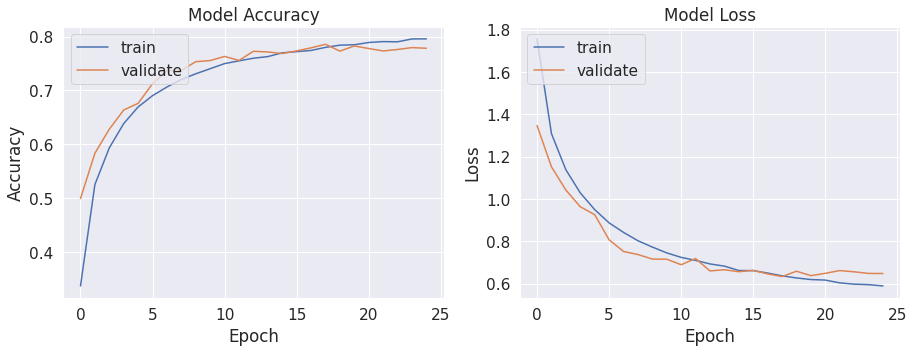

In [43]:
def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()
    return 

# list all data in history
print(history.history.keys())

plotmodelhistory(history)

In [ ]:
print(y_pred.shape)
print(pred.shape)
print(Y_test.shape)
print(y_test.shape)

NameError: ignored

In [ ]:
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [52]:
#CM

def summary_and_confusion_matrix(model_id):
  y_pred_test = model_id.predict(X_test, verbose=2)
  y_pred = np.argmax(y_pred_test, axis=1) # array of class index predictions for all of test data(10000)
  y_pred_max_prob = np.max(y_pred_test, axis=1) # gives the max prob of the array of 10 prob predictions

  Y_true = np.argmax(Y_test,axis=1)
  
  
  #for i in range(10):
      #print(i, confusion_matrix(Y_true,y_pred)[i].sum())
  cm = confusion_matrix(Y_true,y_pred)
  #print(cm)
  report = classification_report(Y_true,y_pred, target_names= class_names)
  print(report)
  

  df_cm = pd.DataFrame(cm, range(10), range(10))
  plt.figure(figsize = (12,10))
  sns.set(font_scale=1.4)#for label size
  sns.heatmap(df_cm, annot=True,annot_kws={"size": 12}, xticklabels = class_names, yticklabels = class_names)
  plt.show()
  return 



313/313 - 1s
              precision    recall  f1-score   support

    airplane       0.80      0.79      0.79      1000
  automobile       0.88      0.92      0.90      1000
        bird       0.84      0.54      0.65      1000
         cat       0.59      0.62      0.61      1000
        deer       0.70      0.81      0.75      1000
         dog       0.69      0.70      0.69      1000
        frog       0.87      0.81      0.83      1000
       horse       0.86      0.80      0.83      1000
        ship       0.79      0.93      0.85      1000
       truck       0.83      0.88      0.85      1000

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.78      0.78      0.78     10000



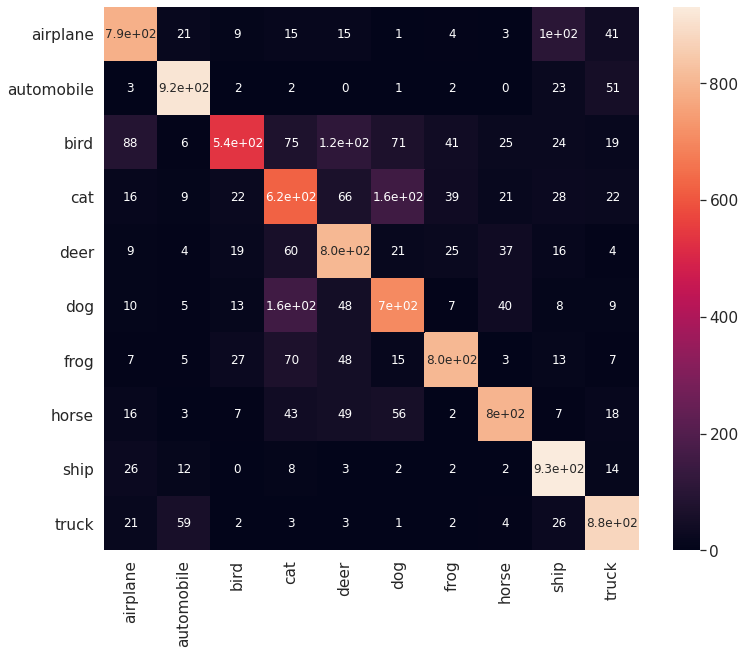

In [53]:
summary_and_confusion_matrix(model)

In [ ]:
#data augmentation and retrain model??

313/313 - 1s


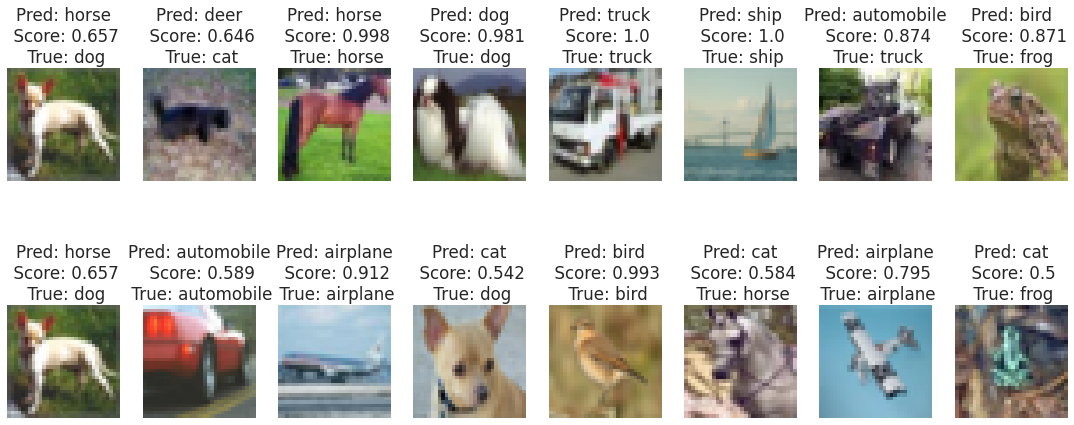

In [75]:
#Show some random examples   


y_pred_test = model.predict(X_test, verbose=2)
y_pred = np.argmax(y_pred_test, axis=1) # array of class index predictions for all of test data(10000)
y_pred_max_prob = np.max(y_pred_test, axis=1) # gives the max prob of the array of 10 prob predictions

Y_true = np.argmax(Y_test,axis=1) # array of actual class labels for all of the test data(10000)

cols = 8
rows = 2
fig = plt.figure(figsize=(2.5 * cols - 1, 4.5 * rows - 1))

for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(Y_test))
        
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(X_test[random_index, :])
        pred_label =  class_names[y_pred[random_index]]
        pred_proba = y_pred_max_prob[random_index]
        true_label = class_names[int(y_test[random_index, 0])]
        ax.set_title("Pred: {}\n Score: {:.3}\n True: {}".format(
               pred_label, pred_proba, true_label
        ))
plt.show()


Y_pred = model.predict(X_test, verbose=2) 
y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_test,axis=1)

In [70]:
# miss-classification examples

def miss_class_examples(model_id):


  y_pred_test = model_id.predict(X_test, verbose=2)
  y_pred = np.argmax(y_pred_test, axis=1) # array of class index predictions for all of test data(10000)
  y_pred_max_prob = np.max(y_pred_test, axis=1) # gives the max prob of the array of 10 prob predictions

  Y_true = np.argmax(Y_test,axis=1) # array of actual class labels for all of the test data(10000)

  miss_class_index = np.where(Y_true != y_pred)[0]

  fig,ax =plt.subplots(4,4,figsize=(15,15))
  ax = ax.ravel()

  for i in np.arange(0,16):
          ax[i].imshow(X_test[miss_class_index[i]])
          #ax[i].set_title('True: %s \n Pred: %s'%(names[Y_true[miss_class_index[i]]],names[y_pred[miss_class_index[i]]]))
          ax[i].set_title("Pred: {}\n Score: {:.3}\n True: {}".format(class_names[y_pred[miss_class_index[i]]],
                                                                      y_pred_max_prob[miss_class_index[i]], 
                                                                      class_names[Y_true[miss_class_index[i]]]))
                                                                      
          plt.subplots_adjust(wspace=1)
  return 


313/313 - 1s


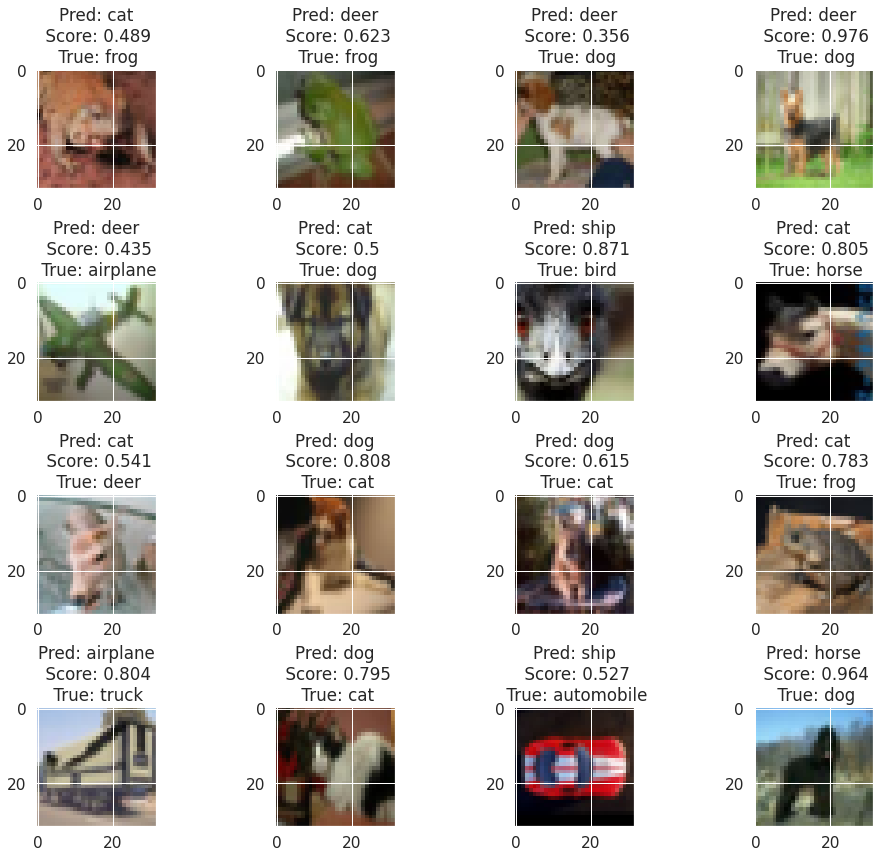

In [71]:
miss_class_examples(model)

Define the model architechture

Convolutional neural networks (CNNs) are the current state-of-the-art model architecture for image classification tasks. CNNs apply a series of filters to the raw pixel data of an image to extract and learn higher-level features, which the model can then use for classification. CNNs contains different components:

Convolutional layers, which apply a specified number of convolution filters to the image. For each subregion, the layer performs a set of mathematical operations to produce a single value in the output feature map. Convolutional layers then typically apply a ReLU activation function) to the output to introduce nonlinearities into the model.

BatchNormalization layers, Batch Normalization is a technical trick to make training faster.

Dropout layers, Dropout is a regularization method, where the layer randomly replaces a proportion of its weights to zero for each training sample. This forces the net to learn features in a distributed way, not relying to much on a particular weight, and therefore improves generalization.

Activation layers, Activation functions are really important for a any Neural Network to learn and make sense of something really complicated and Non-linear complex functional mappings between the inputs and response variable.They introduce non-linear properties to our Network.

Pooling layers, which downsample the image data extracted by the convolutional layers to reduce the dimensionality of the feature map in order to decrease processing time. A commonly used pooling algorithm is max pooling, which extracts subregions of the feature map (e.g., 2x2-pixel tiles), keeps their maximum value, and discards all other values. it gives rotation invariant feature extraction ability to model.

Dense (fully connected) layers, which perform classification on the features extracted by the convolutional layers and downsampled by the pooling layers. In a dense layer, every node in the layer is connected to every node in the preceding layer.

Typically, a CNN is composed of a stack of convolutional modules that perform feature extraction. Each module consists of a convolutional layer followed by a pooling layer. The last convolutional module is followed by one or more dense layers that perform classification. The final dense layer in a CNN contains a single node for each target class in the model (all the possible classes the model may predict), with a softmax activation function to generate a value between 0–1 for each node (the sum of all these softmax values is equal to 1). We can interpret the softmax values for a given image as relative measurements of how likely it is that the image falls into each target class.



In [64]:
print(y_pred[90:100])
print(len(y_pred_test_classes))

print(y_pred_test[100])
print(Y_pred[100][4])

print(y_pred_test_max_probas[0])

[0 6 8 6 4 5 6 0 0 7]
10000
[3.9491523e-04 2.6746069e-05 5.4989206e-03 3.9209317e-02 5.1026672e-01
 1.3279052e-01 6.6130928e-04 3.1087855e-01 3.9697865e-05 2.3334754e-04]
0.5102667
0.5639774


In [134]:
#UPLOAD a file to google colabs

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  image = fn

Saving betts_dog.jpeg to betts_dog.jpeg
Saving betts_dog2.jpeg to betts_dog2.jpeg
Saving betts_dog3.jpeg to betts_dog3.jpeg
Saving chloes_cat.jpeg to chloes_cat.jpeg
Saving dag1.jpeg to dag1 (2).jpeg
Saving dag2.jpeg to dag2.jpeg
Saving dag3.jpeg to dag3.jpeg
Saving dag4.jpeg to dag4.jpeg
Saving dag5.jpeg to dag5.jpeg
Saving Dagny.jpeg to Dagny.jpeg
Saving frog.jpeg to frog.jpeg
Saving plane.jpeg to plane.jpeg
Saving winnie 2.jpeg to winnie 2.jpeg
User uploaded file "betts_dog.jpeg" with length 2623968 bytes
User uploaded file "betts_dog2.jpeg" with length 3005148 bytes
User uploaded file "betts_dog3.jpeg" with length 2786602 bytes
User uploaded file "chloes_cat.jpeg" with length 452861 bytes
User uploaded file "dag1.jpeg" with length 4399412 bytes
User uploaded file "dag2.jpeg" with length 4176274 bytes
User uploaded file "dag3.jpeg" with length 5913500 bytes
User uploaded file "dag4.jpeg" with length 4399412 bytes
User uploaded file "dag5.jpeg" with length 274921 bytes
User uploaded 

In [138]:
image

'winnie 2.jpeg'

In [156]:
#LOAD AND PREPARE AN IMAGE TO PREDICT


def load_image_and_predict(filename, model_id):
    # load the image
    image1 = load_img(filename, target_size=(32, 32), interpolation='nearest', grayscale=False, color_mode='rgb')
    # convert to array
    image = img_to_array(image1)
    # reshape into a single sample with 3 channels
    image = image.reshape(1, 32, 32, 3)
    # prepare pixel data
    image = image.astype('float32')
    image = image / 255.0
    #model = load_model('/cifar_cnn/saved_model.pb')
    result = model_id.predict_classes(image)
    prob = model_id.predict_proba(image)
    final_prob = np.max(prob, axis=1)
    og_image = io.imread(filename)
    plt.imshow(og_image)
    plt.grid(None)
    
    return class_names[result[0]], result[0], final_prob* 100





('bird', 2, array([50.65083], dtype=float32))

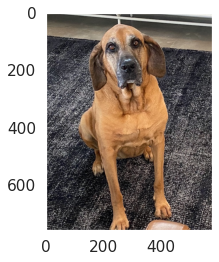

In [159]:
load_image_and_predict('dag5.jpeg', model3)

In [77]:
#MODEL 2

#Lets grayscale and see what happens







In [80]:
g_X_train = rgb2gray(X_train)
g_X_test = rgb2gray(X_test)


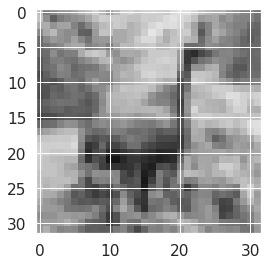

In [81]:
io.imshow(g_X_train[6])

In [90]:
print(g_X_train.shape)  
grey_rgb_X_train = np.repeat(g_X_train[..., np.newaxis], 3, -1)
print(grey_rgb_X_train.shape)  

(50000, 32, 32)
(50000, 32, 32, 3)


In [92]:
print(g_X_test.shape)  
grey_rgb_X_test = np.repeat(g_X_test[..., np.newaxis], 3, -1)
print(grey_rgb_X_test.shape)  

(10000, 32, 32)
(10000, 32, 32, 3)


In [97]:
g_X_train = g_X_train.reshape(-1, 32, 32, 1)
g_X_test = g_X_test.reshape(-1, 32, 32, 1)

print(g_X_train.shape)

(50000, 32, 32, 1)


In [130]:
#MODEL 2.  Greyscale images

batch_size = 64  # number of training samples used at a time to update the weights
nb_classes = 10    # number of output classes
nb_epoch = 25     # number of passes through the entire train dataset before weights "final"
#img_rows, img_cols = 32, 32   # MAYBE USEFUL if inputting different size images for demo
img_rows =X_train[0].shape[0]
img_cols =X_test[0].shape[1]
input_shape = (32, 32, 1)   #Cifar 10 rgb image shape
g_input_shape = (32, 32)
#input_shape = (image_rows, image_cols, 3)   ## MAYBE USEFUL if inputting different size images for demo
nb_filters_1 = 32 # number of convolutional filters to use
nb_filters_2 = 64
nb_filters_3 = 128
pool_size = (3, 3)  # pooling decreases image size, reduces computation, adds translational invariance
#kernel_size = (5, 5)  # convolutional kernel size, slides over image to learn features
#Using kernel_init instead for kernel_size for first try
#opt = keras.optimizers.RMSprop(learning_rate=0.001, decay=1e-6) 


model2 = define_model(nb_filters_1, nb_filters_2, nb_filters_3, input_shape, pool_size)

model2.compile(loss='categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])

history = model2.fit(g_X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, 
          validation_data=(g_X_test, Y_test), shuffle = True)

score = model2.evaluate(g_X_test, Y_test, verbose=1)




print('Test loss score:', score[0])
print('Test accuracy:', score[1])  # this is the one we care about


Epoch 1/25
782/782 [==============================] - 6s 7ms/step - loss: 1.8147 - accuracy: 0.4151 - val_loss: 1.2045 - val_accuracy: 0.5763
Epoch 2/25
782/782 [==============================] - 6s 7ms/step - loss: 1.1480 - accuracy: 0.6000 - val_loss: 0.9638 - val_accuracy: 0.6621
Epoch 3/25
782/782 [==============================] - 6s 7ms/step - loss: 0.9487 - accuracy: 0.6710 - val_loss: 0.8715 - val_accuracy: 0.7002
Epoch 4/25
782/782 [==============================] - 6s 7ms/step - loss: 0.8411 - accuracy: 0.7077 - val_loss: 0.9175 - val_accuracy: 0.6862
Epoch 5/25
782/782 [==============================] - 6s 7ms/step - loss: 0.7716 - accuracy: 0.7324 - val_loss: 0.8291 - val_accuracy: 0.7219
Epoch 6/25
782/782 [==============================] - 6s 7ms/step - loss: 0.7139 - accuracy: 0.7537 - val_loss: 0.6905 - val_accuracy: 0.7653
Epoch 7/25
782/782 [==============================] - 5s 7ms/step - loss: 0.6724 - accuracy: 0.7669 - val_loss: 0.7236 - val_accuracy: 0.7515
Epoch 

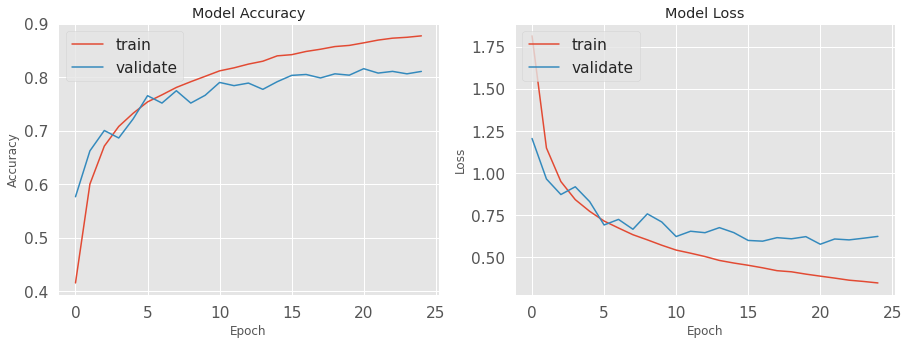

In [131]:
plotmodelhistory(history)

In [132]:
def greyscale_summary_and_confusion_matrix(model_id):
  y_pred_test = model_id.predict(g_X_test, verbose=2)
  y_pred = np.argmax(y_pred_test, axis=1) # array of class index predictions for all of test data(10000)
  y_pred_max_prob = np.max(y_pred_test, axis=1) # gives the max prob of the array of 10 prob predictions

  Y_true = np.argmax(Y_test,axis=1)
  
  
  #for i in range(10):
      #print(i, confusion_matrix(Y_true,y_pred)[i].sum())
  cm = confusion_matrix(Y_true,y_pred)
  #print(cm)
  report = classification_report(Y_true,y_pred, target_names= class_names)
  print(report)
  

  df_cm = pd.DataFrame(cm, range(10), range(10))
  plt.figure(figsize = (12,10))
  sns.set(font_scale=1.4)#for label size
  sns.heatmap(df_cm, annot=True,annot_kws={"size": 12}, xticklabels = class_names, yticklabels = class_names)
  plt.show()
  return 


313/313 - 1s
              precision    recall  f1-score   support

    airplane       0.88      0.78      0.83      1000
  automobile       0.92      0.90      0.91      1000
        bird       0.70      0.75      0.72      1000
         cat       0.66      0.65      0.66      1000
        deer       0.77      0.81      0.79      1000
         dog       0.74      0.77      0.75      1000
        frog       0.77      0.89      0.83      1000
       horse       0.88      0.84      0.86      1000
        ship       0.94      0.84      0.89      1000
       truck       0.89      0.87      0.88      1000

    accuracy                           0.81     10000
   macro avg       0.82      0.81      0.81     10000
weighted avg       0.82      0.81      0.81     10000



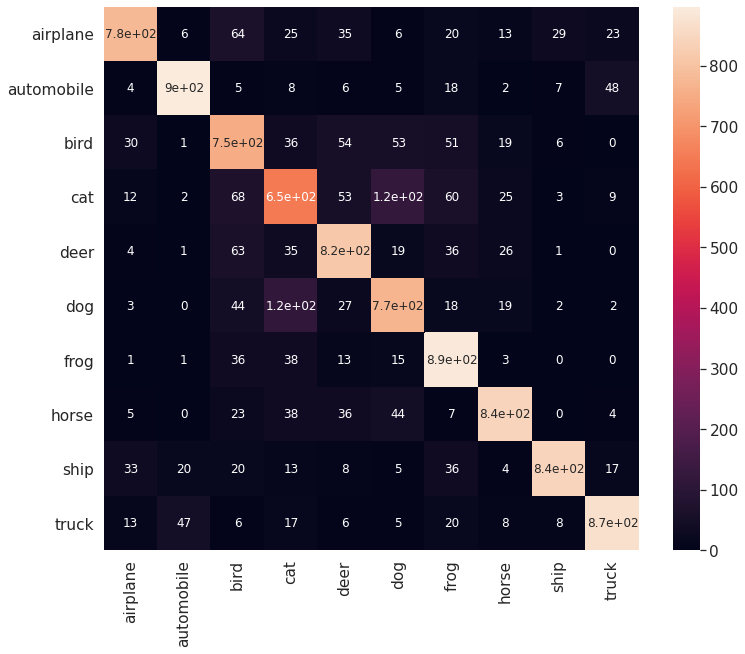

In [133]:
greyscale_summary_and_confusion_matrix(model2)

In [105]:
from tensorflow.keras import regularizers, optimizers

In [168]:
# Model 3
batch_size =64  # number of training samples used at a time to update the weights
nb_classes = 10    # number of output classes
nb_epoch = 50     # number of passes through the entire train dataset before weights "final"
input_shape = (32, 32, 3)   #Cifar 10 rgb image shape
#input_shape = (image_rows, image_cols, 3)   ## MAYBE USEFUL if inputting different size images for demo
nb_filters_1 = 32 # number of convolutional filters to use
nb_filters_2 = 64
nb_filters_3 = 128
pool_size = (3, 3)  # pooling decreases image size, reduces computation, adds translational invariance
#kernel_size = (5, 5)  # convolutional kernel size, slides over image to learn features
#Using kernel_init instead for kernel_size for first try

opt_rms = optimizers.RMSprop(learning_rate=0.001, decay=1e-6) 

model3 = define_model(nb_filters_1, nb_filters_2, nb_filters_3, input_shape, pool_size)

model3.compile(loss='categorical_crossentropy', optimizer= opt_rms, metrics=['accuracy'])

history3 = model3.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, 
          validation_data=(X_test, Y_test), shuffle = True)

score = model3.evaluate(X_test, Y_test, verbose=1)




Epoch 1/50
782/782 [==============================] - 7s 9ms/step - loss: 1.5996 - accuracy: 0.4277 - val_loss: 1.3143 - val_accuracy: 0.5381
Epoch 2/50
782/782 [==============================] - 7s 8ms/step - loss: 1.1348 - accuracy: 0.6042 - val_loss: 1.0923 - val_accuracy: 0.6114
Epoch 3/50
782/782 [==============================] - 7s 9ms/step - loss: 0.9832 - accuracy: 0.6637 - val_loss: 0.9739 - val_accuracy: 0.6608
Epoch 4/50
782/782 [==============================] - 7s 9ms/step - loss: 0.8848 - accuracy: 0.6998 - val_loss: 0.8587 - val_accuracy: 0.6994
Epoch 5/50
782/782 [==============================] - 6s 8ms/step - loss: 0.8231 - accuracy: 0.7223 - val_loss: 0.9600 - val_accuracy: 0.6824
Epoch 6/50
782/782 [==============================] - 7s 8ms/step - loss: 0.7780 - accuracy: 0.7392 - val_loss: 0.7406 - val_accuracy: 0.7408
Epoch 7/50
782/782 [==============================] - 7s 8ms/step - loss: 0.7310 - accuracy: 0.7524 - val_loss: 0.7729 - val_accuracy: 0.7377
Epoch 

In [169]:
print('Test loss score:', score[0])
print('Test accuracy:', score[1])  


Test loss score: 0.5834773182868958
Test accuracy: 0.8245000243186951


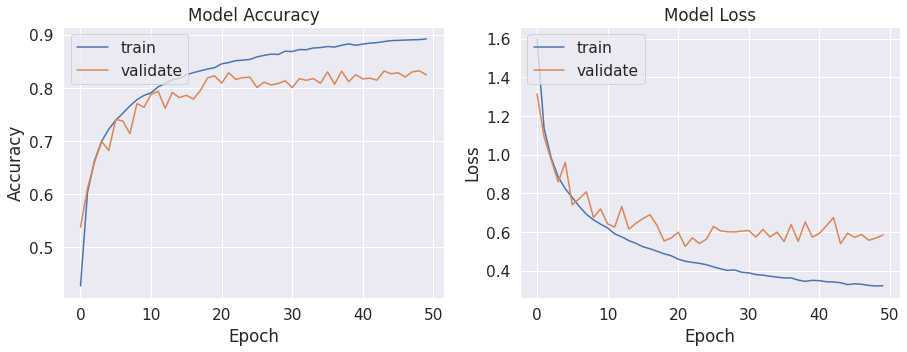

In [170]:
plotmodelhistory(history3)

In [165]:
# MODEL 4
batch_size = 64  # number of training samples used at a time to update the weights
nb_classes = 10    # number of output classes
nb_epoch = 50     # number of passes through the entire train dataset before weights "final"
input_shape = (32, 32, 3)   #Cifar 10 rgb image shape
#input_shape = (image_rows, image_cols, 3)   ## MAYBE USEFUL if inputting different size images for demo
nb_filters_1 = 32 # number of convolutional filters to use
nb_filters_2 = 64
nb_filters_3 = 128
pool_size = (3, 3)  # pooling decreases image size, reduces computation, adds translational invariance
#kernel_size = (5, 5)  # convolutional kernel size, slides over image to learn features
#Using kernel_init instead for kernel_size for first try

opt_rms = optimizers.RMSprop(learning_rate=0.001, decay=1e-6) 

model4 = define_model(nb_filters_1, nb_filters_2, nb_filters_3, input_shape, pool_size)

model4.compile(loss='categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])

history4 = model4.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, 
          validation_data=(X_test, Y_test), shuffle = True)

score = model4.evaluate(X_test, Y_test, verbose=1)


Epoch 1/50
782/782 [==============================] - 6s 8ms/step - loss: 1.5661 - accuracy: 0.4327 - val_loss: 1.2206 - val_accuracy: 0.5570
Epoch 2/50
782/782 [==============================] - 6s 8ms/step - loss: 1.1419 - accuracy: 0.5939 - val_loss: 1.0818 - val_accuracy: 0.6213
Epoch 3/50
782/782 [==============================] - 6s 8ms/step - loss: 0.9750 - accuracy: 0.6593 - val_loss: 0.8610 - val_accuracy: 0.7041
Epoch 4/50
782/782 [==============================] - 6s 8ms/step - loss: 0.8646 - accuracy: 0.7017 - val_loss: 0.7688 - val_accuracy: 0.7297
Epoch 5/50
782/782 [==============================] - 6s 8ms/step - loss: 0.7939 - accuracy: 0.7276 - val_loss: 0.9595 - val_accuracy: 0.6689
Epoch 6/50
782/782 [==============================] - 6s 8ms/step - loss: 0.7385 - accuracy: 0.7457 - val_loss: 0.6620 - val_accuracy: 0.7752
Epoch 7/50
782/782 [==============================] - 6s 8ms/step - loss: 0.6897 - accuracy: 0.7636 - val_loss: 0.6275 - val_accuracy: 0.7856
Epoch 

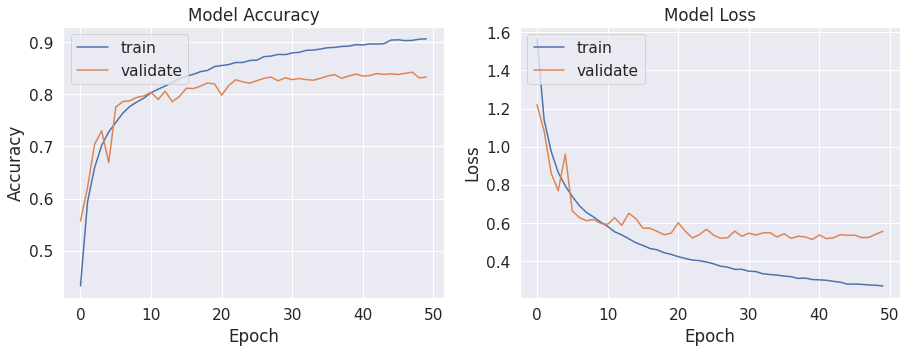

In [166]:
plotmodelhistory(history4)